### Import Packages 

In [1]:
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
warnings.simplefilter('ignore') # filter some warning messages
xr.set_options(display_style="html")  #display dataset nicely 
import cmocean as cm

# cartopy 
import cartopy.crs as ccrs       # ccrs contains information about projections
import cartopy                   # contains all other cartopy functions/classes/methods
import cartopy.feature as cfeature

### Step 1. Set up Dask for lazy/parallel computing 

In [2]:
from dask_gateway import Gateway
from dask.distributed import Client

# gateway = Gateway()
# cluster = gateway.new_cluster()
# cluster.adapt(minimum=1, maximum=60)
# client = Client(cluster)
# cluster
gateway = Gateway()
cluster = gateway.new_cluster(worker_memory=8)  # specify worker memory, max = 8
cluster.adapt(minimum=1, maximum=60)  # specify how many workers 
client = Client(cluster)
cluster

click on the above link to access the Dask dashboard

### Step 2. Load the MUR SST Dataset

2.1 Load the MUR SST dataset from AWS 

2.2 Load the MUR SST dataset from PODAAC thredds server 

2.3 Mask out erroneous data near poles 

In [3]:
# 2.1 load MUR SST dataset from AWS
%time 
AWS_url = 'https://mur-sst.s3.us-west-2.amazonaws.com/zarr-v1'
ds_sst = xr.open_zarr(AWS_url, consolidated=True)
ds_sst

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,141791 Tasks,141790 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [4]:
# 2.2 load the MUR SST dataset from PODAAC thredds server 
PODAAC_url = ('https://thredds.jpl.nasa.gov/thredds/dodsC/OceanTemperature/MUR-JPL-L4-GLOB-v4.1.nc')
full_sst = xr.open_dataset(PODAAC_url)
full_sst

<xarray.Dataset>
Dimensions:           (lat: 17999, lon: 36000, time: 7122)
Coordinates:
  * lat               (lat) float32 -89.99 -89.98 -89.97 ... 89.97 89.98 89.99
  * lon               (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2021-12-0...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
Attributes:
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    comment:                    MUR = "Multi-scale Ultra-high Reolution"
    license:                    These data are available free of charge under...
    id:                         MUR-JPL-L4-GLOB-v04.1
    naming_authority:           org.ghrsst
    product_version:            04.1
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    gds_version_id:             2.0
    netcdf_version_id:          4.1
    date_created:               20180519T172046Z
    start_time:                 20180427T090000Z
    stop_time:                  20180427T090000Z
    time_coverage_start:        20180426T210000Z
    time_coverage_end:          20180427T210000Z
    file_quality_level:         1
    source:                     MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRR1...
    platform:                   Terra, Aqua, GCOM-W, NOAA-19, MetOp-A, Buoys/...
    sensor:                     MODIS, AMSR2, AVHRR, in-situ
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    southernmost_latitude:      -90.0
    northernmost_latitude:      90.0
    westernmost_longitude:      -180.0
    easternmost_longitude:      180.0
    spatial_resolution:         0.01 degrees
    geospatial_lat_units:       degrees north
    geospatial_lat_resolution:  0.01 degrees
    geospatial_lon_units:       degrees east
    geospatial_lon_resolution:  0.01 degrees
    acknowledgment:             Please acknowledge the use of these data with...
    creator_name:               JPL MUR SST project
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    creator_url:                http://mur.jpl.nasa.gov
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

Note that the MUR SST dataset from AWS only has data available from 2002-Jan 2020, where as the dataset from PODAAC has data availble to present day (Nov. 2021). 

##### There are some erroneous SSTs near land at the poles so we will mask those out based on sea-ice fraction 

In [5]:
sst = ds_sst['analysed_sst']

cond = (ds_sst.mask==1) & ((ds_sst.sea_ice_fraction<.15) | np.isnan(ds_sst.sea_ice_fraction)) 
# don't fully understand the above step 

sst_masked = ds_sst['analysed_sst'].where(cond)

sst_masked

,Array,Chunk
Bytes,16.70 TB,129.53 MB
Shape,"(6443, 17999, 36000)","(5, 1799, 3600)"
Count,1276113 Tasks,141790 Chunks
Type,float32,numpy.ndarray


### Step 3. Create daily, monthly, yearly, and seasonal climatologies and anomalies 

#### let's create daily, monthly, yearly, and seasonal climatologies and anomalies 

In [7]:
%%time
#create a daily climatology and anomaly
daily_clima = sst_masked.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)

daily_anom = sst_masked.groupby('time.dayofyear')-daily_clima  #take out annual mean to remove trends

#create a monthly dataset, climatology, and anomaly
sst_monthly = sst_masked.resample(time='1MS').mean('time',keep_attrs=True,skipna=False)

monthly_clima = sst_monthly.groupby('time.month').mean('time',keep_attrs=True,skipna=False)

monthly_anom = sst_monthly.groupby('time.month')-monthly_clima  #take out annual mean to remove trends

# create a yearly dataset, climatology, and anomaly 

sst_yearly = sst_masked.resample(time='1Y').mean('time',keep_attrs=True,skipna=False)

yearly_clima = sst_yearly.groupby('time.year').mean('time',keep_attrs=True,skipna=False)

yearly_anom = sst_yearly.groupby('time.year')-yearly_clima


CPU times: user 13.3 s, sys: 310 ms, total: 13.6 s
Wall time: 13.6 s


#### seasonal climas 

In [50]:
seasonal_clima = sst_monthly.groupby('time.season').mean('time',keep_attrs=True,skipna=False)

In [9]:
seasonal_anom = sst_monthly.groupby('time.season')-seasonal_clima

In [11]:
sst_seasonal = sst_monthly.resample(time='3M').mean()

In [12]:
sst_seasonal

,Array,Chunk
Bytes,186.61 GB,25.91 MB
Shape,"(72, 17999, 36000)","(1, 1799, 3600)"
Count,1752853 Tasks,7920 Chunks
Type,float32,numpy.ndarray


In [14]:
JJA = sst_seasonal[0::4]
SON = sst_seasonal[1::4]
DJF = sst_seasonal[2::4]
MAM = sst_seasonal[3::4]

In [15]:
# calculate seasonal climas and anoms 

JJA_clima = JJA.mean(dim='time')
JJA_anom = JJA - JJA_clima 

SON_clima = SON.mean(dim='time')
SON_anom = SON - SON_clima 

DJF_clima = DJF.mean(dim='time')
DJF_anom = DJF - DJF_clima 

MAM_clima = MAM.mean(dim='time')
MAM_anom = MAM - MAM_clima 

In [146]:
a1 = 10
i = 1
'a' + str(i) + '= 10'

'a1= 10'

In [149]:
i = 10
exec('a' + str(i) +  '= 10')

In [150]:
a10

10

In [126]:
seasons = [DJF,MAM,JJA,SON]
for season in seasons:
    exec(i)_clima = i.mean(dim='time')
    i_anom = i-i_clima

### Make global plots using xarray coarsen 

In [17]:
mybirthday = sst_masked.sel(time='2019-07-30')

In [18]:
mybirthday

<xarray.DataArray 'analysed_sst' (time: 1, lat: 17999, lon: 36000)>
dask.array<getitem, shape=(1, 17999, 36000), dtype=float32, chunksize=(1, 1799, 3600), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2019-07-30T09:00:00
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [28]:
mybirthday = mybirthday.coarsen(lat=10,lon=10,boundary='trim').mean()

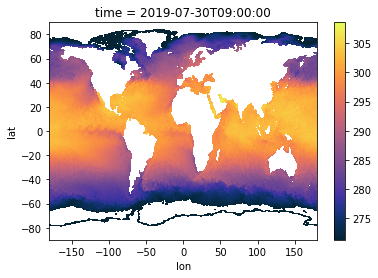

In [31]:
mybirthday.plot(cmap='cmo.thermal')

In [32]:
lat = np.arange(-89.99,89.99+.25,.25)

In [33]:
lon = np.arange(-180,180+.25,.25)

In [36]:
halloween = sst_masked.sel(time='2004-10-31').interp(lon=lon,lat=lat)

In [37]:
halloween

<xarray.DataArray 'analysed_sst' (time: 1, lat: 721, lon: 1441)>
dask.array<transpose, shape=(1, 721, 1441), dtype=float32, chunksize=(1, 721, 1441), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2004-10-31T09:00:00
  * lon      (lon) float64 -180.0 -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
  * lat      (lat) float64 -89.99 -89.74 -89.49 -89.24 ... 89.51 89.76 90.01
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

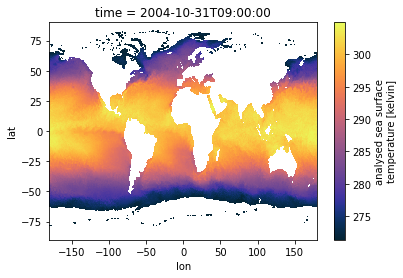

In [38]:
halloween.plot(cmap='cmo.thermal')

### Step 4: Slice the dataset for desired regions (ATOMIC and LIS)

#### Let's slice the datasets for ATOMIC sampling area
##### Overall question: Has SST changed historically in the ATOMIC area. If so, how?

In [51]:
daily_sst = sst_masked.sel(lon=slice(-62,-48),lat=slice(4,14))
daily_clima = daily_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
daily_anom = daily_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
sst_monthly = sst_monthly.sel(lon=slice(-62,-48),lat=slice(4,14))
monthly_clima = monthly_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
monthly_anom = monthly_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
sst_yearly = sst_yearly.sel(lon=slice(-62,-48),lat=slice(4,14))
yearly_clima = yearly_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
yearly_anom = yearly_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
seasonal_clima = seasonal_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
JJA = JJA.sel(lon=slice(-62,-48),lat=slice(4,14))
JJA_clima = JJA_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
JJA_anom = JJA_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
SON = SON.sel(lon=slice(-62,-48),lat=slice(4,14))
SON_clima = SON_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
SON_anom = SON_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
DJF = DJF.sel(lon=slice(-62,-48),lat=slice(4,14))
DJF_clima = DJF_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
DJF_anom = DJF_anom.sel(lon=slice(-62,-48),lat=slice(4,14))
MAM = MAM.sel(lon=slice(-62,-48),lat=slice(4,14))
MAM_clima = MAM_clima.sel(lon=slice(-62,-48),lat=slice(4,14))
MAM_anom = MAM_anom.sel(lon=slice(-62,-48),lat=slice(4,14))

#### spatially average ATOMIC area and look at trends 

In [40]:
daily_spatial = daily_sst.mean(dim=('lon','lat')).load()

In [41]:
daily_anom_spatial = daily_anom.mean(dim=('lon','lat')).load()

In [42]:
monthly_spatial = sst_monthly.mean(dim=('lon','lat')).load()
monthly_anom_spatial = monthly_anom.mean(dim=('lon','lat')).load()

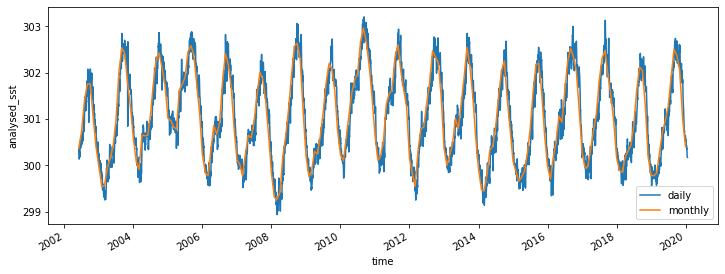

In [44]:
fig = plt.figure(figsize=(12,4))
daily_spatial.plot(label='daily')
monthly_spatial.plot(label='monthly')
plt.legend()

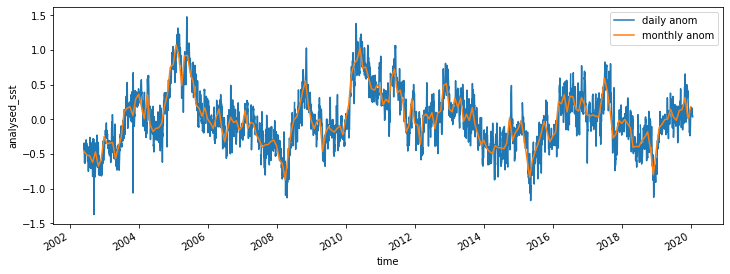

In [45]:
fig = plt.figure(figsize=(12,4))
daily_anom_spatial.plot(label='daily anom')
monthly_anom_spatial.plot(label='monthly anom')
plt.legend()

### Seasonal Climatologies 

In [52]:
seasonal_clima.load()

<xarray.DataArray 'analysed_sst' (season: 4, lat: 1001, lon: 1401)>
array([[[      nan,       nan,       nan, ..., 300.5915 , 300.59262,
         300.59406],
        [      nan,       nan,       nan, ..., 300.5906 , 300.59183,
         300.59323],
        [      nan,       nan,       nan, ..., 300.5901 , 300.59143,
         300.59274],
        ...,
        [300.50214, 300.50278, 300.50336, ..., 299.52094, 299.52005,
         299.51932],
        [300.5022 , 300.50287, 300.50354, ..., 299.51904, 299.51782,
         299.51697],
        [300.5025 , 300.50305, 300.5037 , ..., 299.51724, 299.51566,
         299.5147 ]],

       [[      nan,       nan,       nan, ..., 301.3552 , 301.35596,
         301.35648],
        [      nan,       nan,       nan, ..., 301.3579 , 301.3586 ,
         301.35922],
        [      nan,       nan,       nan, ..., 301.36072, 301.36136,
         301.36197],
...
        [300.50763, 300.5068 , 300.50613, ..., 299.05472, 299.0542 ,
         299.05353],
        [300.5089 , 300.50766, 300.5065 , ..., 299.05246, 299.05188,
         299.05118],
        [300.50964, 300.50803, 300.50656, ..., 299.05057, 299.04996,
         299.04907]],

       [[      nan,       nan,       nan, ..., 301.14084, 301.14096,
         301.14084],
        [      nan,       nan,       nan, ..., 301.14566, 301.14566,
         301.14563],
        [      nan,       nan,       nan, ..., 301.1504 , 301.15057,
         301.1508 ],
        ...,
        [302.3543 , 302.35175, 302.34924, ..., 301.26624, 301.26703,
         301.26782],
        [302.3534 , 302.35065, 302.34796, ..., 301.26523, 301.26617,
         301.26715],
        [302.35272, 302.35004, 302.34732, ..., 301.26364, 301.26477,
         301.26584]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 4.0 4.01 4.02 4.03 4.04 ... 13.97 13.98 13.99 14.0
  * lon      (lon) float32 -62.0 -61.99 -61.98 -61.97 ... -48.02 -48.01 -48.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    comment:        "Final" version using Multi-Resolution Variational Analys...
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_max:      32767
    valid_min:      -32767

In [ ]:
'vmin':295,'vmax':303,'levels':50,

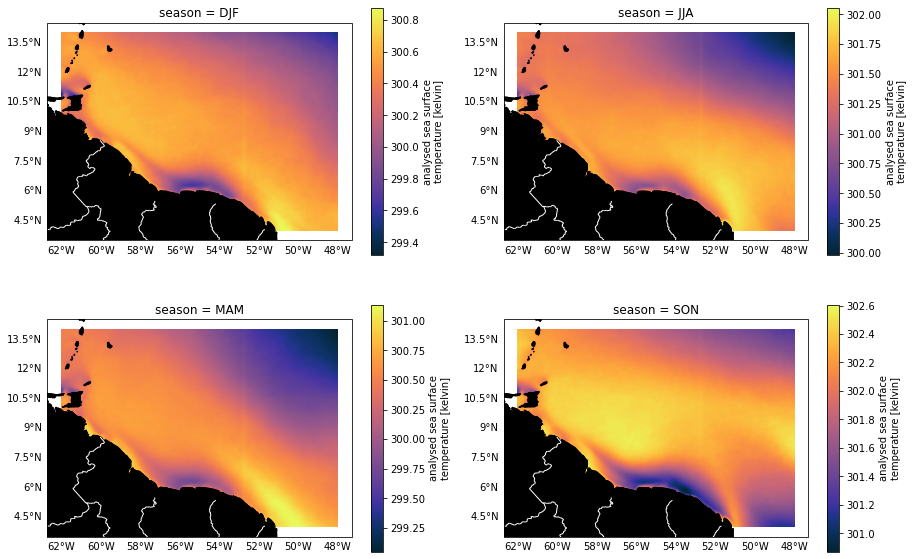

In [53]:
# Seasonal plots using cartopy 

kw = {'cmap':'cmo.thermal','transform':ccrs.PlateCarree()}
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(15,10),constrained_layout=False,
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

seasonal_clima.isel(season=0).plot(ax=axs[0],**kw,zorder=0)
seasonal_clima.isel(season=1).plot(ax=axs[1],**kw,zorder=0)
seasonal_clima.isel(season=2).plot(ax=axs[2],**kw,zorder=0)
seasonal_clima.isel(season=3).plot(ax=axs[3],**kw,zorder=0)

for i in [0,1,2,3]:
    axs[i].coastlines()
    axs[i].add_feature(cartopy.feature.BORDERS,color='w',zorder=2)
#     axs[i].add_feature(cartopy.feature.RIVERS,zorder=2)
    axs[i].add_feature(cartopy.feature.LAND,color='k',zorder=1)
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(),
             draw_labels=True,
             linewidth=1,
             color='gray',
             alpha=0,
             linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

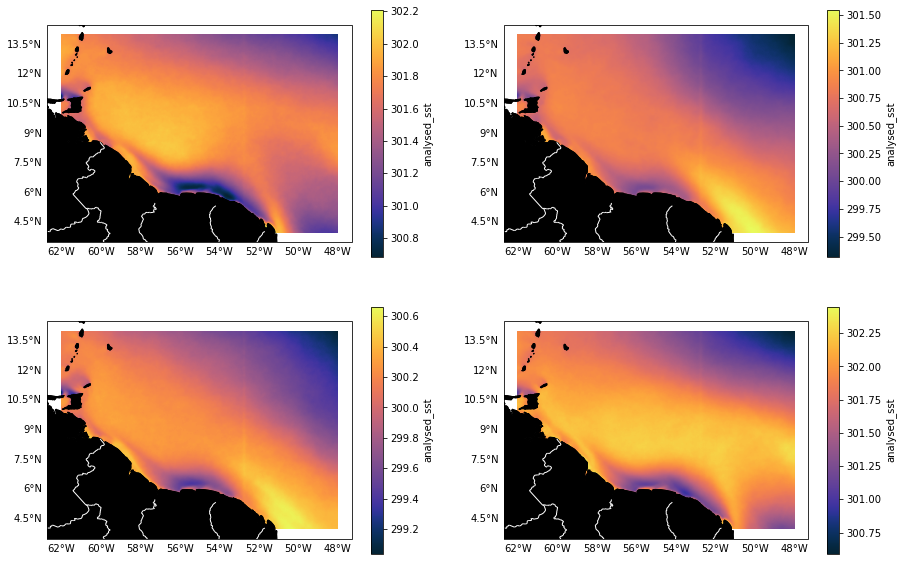

In [54]:
# Seasonal plots using cartopy 

kw = {'cmap':'cmo.thermal','transform':ccrs.PlateCarree()}
fig, axs = plt.subplots(ncols=2, nrows=2,figsize=(15,10),constrained_layout=False,
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

DJF_clima.plot(ax=axs[0],**kw,zorder=0)
JJA_clima.plot(ax=axs[1],**kw,zorder=0)
MAM_clima.plot(ax=axs[2],**kw,zorder=0)
SON_clima.plot(ax=axs[3],**kw,zorder=0)

for i in [0,1,2,3]:
    axs[i].coastlines()
    axs[i].add_feature(cartopy.feature.BORDERS,color='w',zorder=2)
#     axs[i].add_feature(cartopy.feature.RIVERS,zorder=2)
    axs[i].add_feature(cartopy.feature.LAND,color='k',zorder=1)
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(),
             draw_labels=True,
             linewidth=1,
             color='gray',
             alpha=0,
             linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

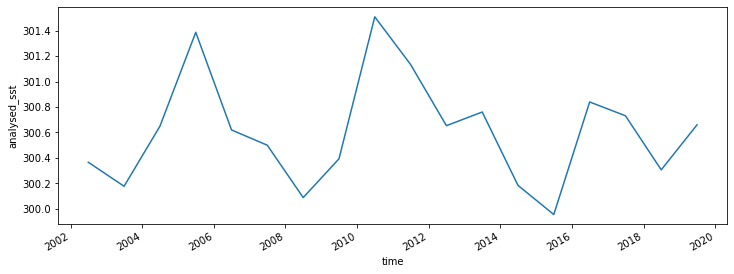

In [70]:
# take seasonal spatial averages and plot 
JJA_spatial = JJA.mean(dim=('lat','lon'))
JJA_spatial.plot(figsize=(12,4))

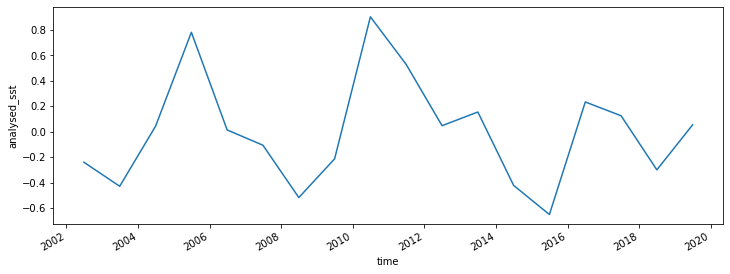

In [69]:
JJA_anom_spatial = JJA_anom.mean(dim=('lat','lon'))
JJA_anom_spatial.plot(figsize=(12,4))

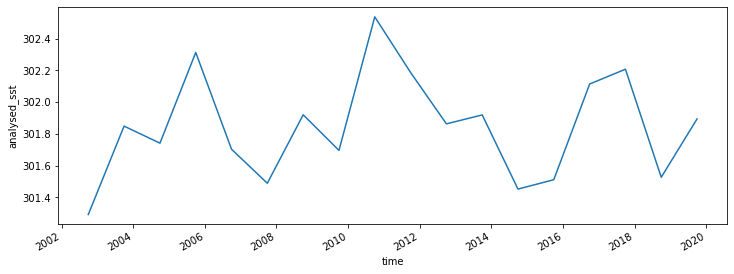

In [68]:
# take seasonal spatial averages and plot 
SON_spatial = SON.mean(dim=('lat','lon'))
SON_spatial.plot(figsize=(12,4))

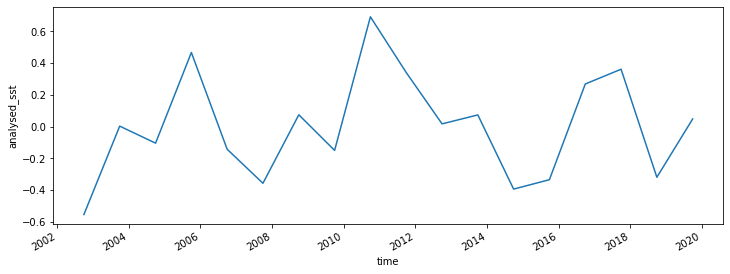

In [67]:
SON_anom_spatial = SON_anom.mean(dim=('lat','lon'))
SON_anom_spatial.plot(figsize=(12,4))

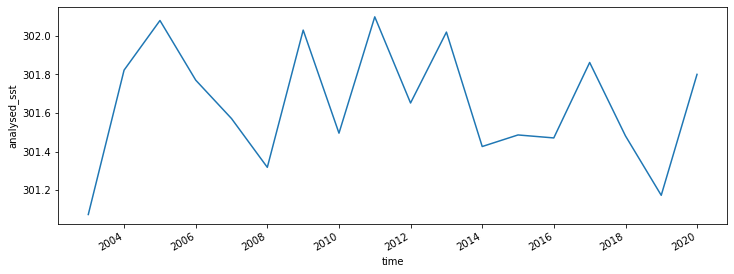

In [66]:
# take seasonal spatial averages and plot 
DJF_spatial = DJF.mean(dim=('lat','lon'))
DJF_spatial.plot(figsize=(12,4))

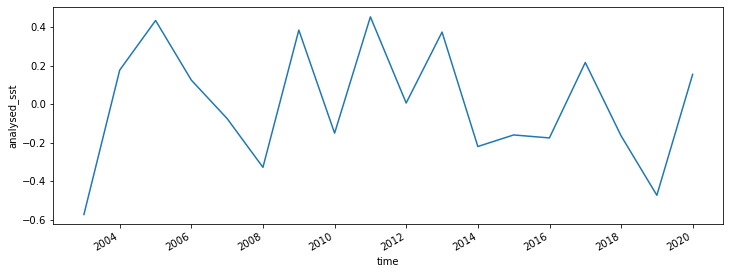

In [65]:
DJF_anom_spatial = DJF_anom.mean(dim=('lat','lon'))
DJF_anom_spatial.plot(figsize=(12,4))

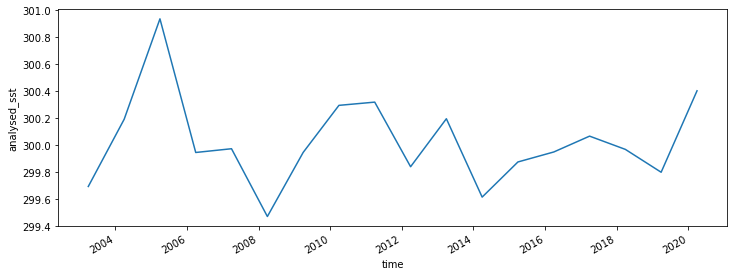

In [63]:
# take seasonal spatial averages and plot 
MAM_spatial = MAM.mean(dim=('lat','lon'))
MAM_spatial.plot(figsize=(12,4))

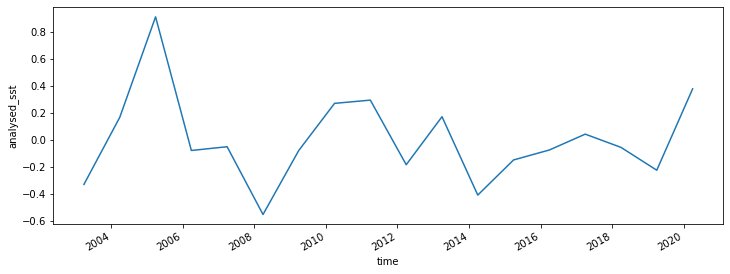

In [64]:
MAM_anom_spatial = MAM_anom.mean(dim=('lat','lon'))
MAM_anom_spatial.plot(figsize=(12,4))

### stats

In [71]:
from scipy import stats

In [88]:
JJA_spatial.load()

<xarray.DataArray 'analysed_sst' (time: 18)>
array([300.36514, 300.17627, 300.64914, 301.3873 , 300.61932, 300.49902,
       300.08737, 300.39212, 301.50897, 301.13467, 300.65277, 300.7605 ,
       300.1831 , 299.9542 , 300.79224, 300.73077, 300.3055 , 300.6595 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-06-30 2003-06-30 ... 2019-06-30

In [90]:
stats.describe(JJA_spatial)

DescribeResult(nobs=18, minmax=(299.9542, 301.50897), mean=300.60324, variance=0.17936361, skewness=0.6176016330718994, kurtosis=-0.1760088308457477)

In [73]:
stats.describe?

Signature: stats.describe(a, axis=0, ddof=1, bias=True, nan_policy='propagate')
Docstring:
Compute several descriptive statistics of the passed array.

Parameters
----------
a : array_like
   Input data.
axis : int or None, optional
   Axis along which statistics are calculated. Default is 0.
   If None, compute over the whole array `a`.
ddof : int, optional
    Delta degrees of freedom (only for variance).  Default is 1.
bias : bool, optional
    If False, then the skewness and kurtosis calculations are corrected for
    statistical bias.
nan_policy : {'propagate', 'raise', 'omit'}, optional
    Defines how to handle when input contains nan.
    The following options are available (default is 'propagate'):

      * 'propagate': returns nan
      * 'raise': throws an error
      * 'omit': performs the calculations ignoring nan values

Returns
-------
nobs : int or ndarray of ints
   Number of observations (length of data along `axis`).
   When 'omit' is chosen as nan_policy, each colum

In [85]:
JJA_spatial.min()

<xarray.DataArray 'analysed_sst' ()>
dask.array<nanmin-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

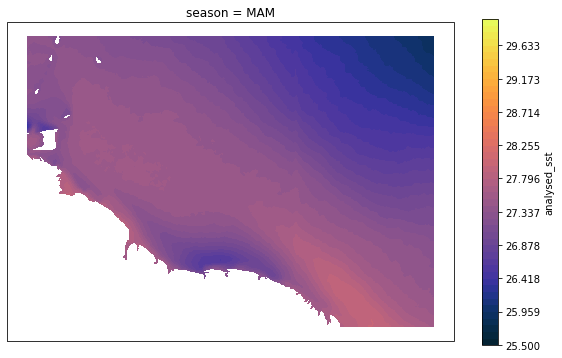

In [29]:
kw = {'vmin':25.5,'vmax':30,'levels':50,'cmap':'cmo.thermal','transform':ccrs.PlateCarree()}
fig = plt.figure(figsize=(10,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ATOMIC_seasonal.isel(season=2).plot(**kw,zorder=0)